# EfficientNet CNN

Notebook by Martijn de Vries <br>
martijndevries91@gmail.com

NOTE: the EfficientNetB0 model that I use in this notebook has trouble saving with some version of tensorflow (versions 2.10 and higher) <br>
I used the following fix to make it work on my machine (found in the comments here: https://github.com/keras-team/keras/issues/17199):

location: lib/python3.10/site-packages/keras/applications/efficientnet.py (py3.10) <br>
EDIT this: <br>
<code> x = layers.Rescaling(1.0 / tf.math.sqrt(IMAGENET_STDDEV_RGB))(x) </code> <br>
TO: <br>
<code> x = layers.Rescaling(
    [1.0 / math.sqrt(stddev) for stddev in IMAGENET_STDDEV_RGB]
)(x) </code>



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os 

#tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array, load_img, smart_resize
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import EfficientNetB0

2023-06-08 09:07:59.105923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
np.random.seed(123)

I can use image_dataset_from_directory to load in the images.
Note that even though the images are grayscale, i have to use rgb color mode because that's the format EfficientNet requires

In [3]:
train_ds = image_dataset_from_directory('../img_data/train_symbols/', image_size=(100,100),
                                      batch_size=200, seed=123, validation_split=0.10,
                                       subset='training', labels ='inferred', color_mode='rgb', label_mode='categorical')  

val_ds = image_dataset_from_directory('../img_data/train_symbols/', image_size=(100,100),
                                      batch_size=200, seed=123, validation_split=0.10,
                                       subset='validation', labels ='inferred', color_mode='rgb', label_mode='categorical')  

Found 83938 files belonging to 100 classes.
Using 75545 files for training.


2023-06-08 09:08:17.474089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 83938 files belonging to 100 classes.
Using 8393 files for validation.


Let's look at the class names:

In [4]:
train_ds.class_names[:5]

['label_!', 'label_(', 'label_)', 'label_+', 'label_,']

I'll want to save these, so I can access them when it's time to make predictions

In [5]:
with open('../class_names.txt', 'w') as f:
    for i, label in enumerate(train_ds.class_names):
        f.write(str(i)+  ' ' + label + '\n')
        

Let's also look at the images that are loaded in by image_dataset_from_directory

In [6]:
img_list = []
for images, labels in train_ds.take(1):
    for i in range(30):
        img_list.append(images[i])

In [7]:
img_list[3].shape

TensorShape([100, 100, 3])

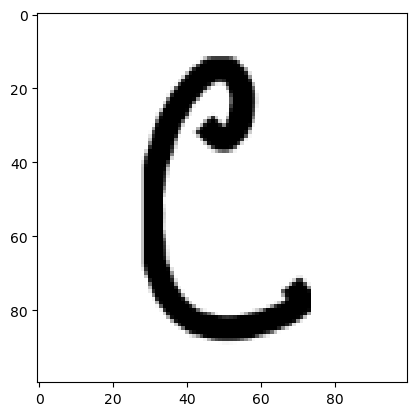

In [8]:
plt.imshow(img_list[4][:,:,0], cmap='gray');

That looks alright! It's important that the size of the symbols is roughtly similar to the symbol size out of the pre-processing pipeline.

Now we can set up the neural network. For optimal performance, I'll use the EfficientNetB0 network, and re-train it using my data

In [9]:
es = EarlyStopping(patience=5)

In [12]:
efficient_net = EfficientNetB0(
    weights='imagenet',
    input_shape=(100,100, 3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dropout(0.25))
model.add(Dense(units = 64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 64, activation='relu'))
model.add(Dense(units = 100, activation='softmax'))
model.summary()


model.compile(
    optimizer=Adam(learning_rate = 0.0005),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                81984     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 100)               6500      
                                                                 
Total params: 4,142,215
Trainable params: 4,100,192
No

Now we can fit the model. NB: on my local machine this took about 4hrs

In [ ]:
h = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[es])

Epoch 1/30
378/378 [==============================] - 1274s 3s/step - loss: 1.0933 - accuracy: 0.7599 - val_loss: 0.3551 - val_accuracy: 0.9149
Epoch 2/30
378/378 [==============================] - 1197s 3s/step - loss: 0.3364 - accuracy: 0.9117 - val_loss: 0.2639 - val_accuracy: 0.9318
Epoch 3/30
378/378 [==============================] - 1265s 3s/step - loss: 0.2488 - accuracy: 0.9314 - val_loss: 0.2171 - val_accuracy: 0.9430
Epoch 4/30
378/378 [==============================] - 1210s 3s/step - loss: 0.2132 - accuracy: 0.9395 - val_loss: 0.2079 - val_accuracy: 0.9435
Epoch 5/30
378/378 [==============================] - 1178s 3s/step - loss: 0.1896 - accuracy: 0.9449 - val_loss: 0.1905 - val_accuracy: 0.9502
Epoch 6/30
 44/378 [==>...........................] - ETA: 17:10 - loss: 0.1583 - accuracy: 0.9539

An accuracy of 95% on the validation data is pretty good! Now we can save the model

In [90]:
model_dir = '../CNN_model'
if os.path.isdir(model_dir) == False: os.mkdir(model_dir)

In [91]:
model.save(model_dir + '/efficientnet_model.h5')

In [93]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dropout_8 (Dropout)         (None, 1280)              0         
                                                                 
 dense_14 (Dense)            (None, 64)                81984     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 100)               6500      
                                                                 
Total params: 4,142,215
Trainable params: 4,100,192
No

Let's also try efficientnet B2

In [18]:
from tensorflow.keras.applications import EfficientNetB2

In [19]:
efficient_net = EfficientNetB2(
    weights='imagenet',
    input_shape=(100, 100, 3),
    include_top=False,
    pooling='max'
)

model = Sequential()
model.add(efficient_net)
model.add(Dropout(0.25))
model.add(Dense(units = 32, activation='relu'))
model.add(Dense(units = 100, activation='softmax'))
model.summary()


model.compile(
    optimizer=Adam(learning_rate = 0.0005),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

31790344/31790344 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 1408)             7768569   
                                                                 
 dropout_1 (Dropout)         (None, 1408)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                45088     
                                                                 
 dense_3 (Dense)             (None, 100)               3300      
                                                                 
Total params: 7,816,957
Trainable params: 7,749,382
Non-trainable params: 67,575
_________________________________________________________________


In [20]:
h = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[es])

Epoch 1/30
396/396 [==============================] - 1934s 5s/step - loss: 0.7638 - accuracy: 0.8303 - val_loss: 0.3419 - val_accuracy: 0.8851
Epoch 2/30
396/396 [==============================] - 1889s 5s/step - loss: 0.2237 - accuracy: 0.9363 - val_loss: 0.2042 - val_accuracy: 0.9452
Epoch 3/30
396/396 [==============================] - 1886s 5s/step - loss: 0.1735 - accuracy: 0.9474 - val_loss: 0.1916 - val_accuracy: 0.9462
Epoch 4/30
396/396 [==============================] - 1892s 5s/step - loss: 0.1474 - accuracy: 0.9533 - val_loss: 0.2009 - val_accuracy: 0.9450
Epoch 5/30
396/396 [==============================] - 1902s 5s/step - loss: 0.1356 - accuracy: 0.9567 - val_loss: 0.1943 - val_accuracy: 0.9491
Epoch 6/30
396/396 [==============================] - 1894s 5s/step - loss: 0.1204 - accuracy: 0.9615 - val_loss: 0.1752 - val_accuracy: 0.9546
Epoch 7/30
396/396 [==============================] - 1890s 5s/step - loss: 0.1127 - accuracy: 0.9632 - val_loss: 0.1933 - val_accuracy: